In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
# from torchsummary import summary

from torchvision import transforms
from torchvision.utils import make_grid
#from torchvision.datasets import CelebA
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(64)


In [3]:
def show_tensor_image(image_tensor, num_images=16, size=(3,64,64), nrow=3):
  '''
  텐서 그리드로 시각화
  '''
  image_tensor = (image_tensor+1)/2
  images_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(images_unflat[:num_images],nrow=nrow)
  plt.imshow(image_grid.permute(1,2,0).squeeze())
  plt.show()

def make_grad_hook():
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook


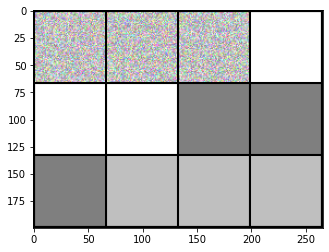

In [4]:
##시각화 테스트
noise = torch.rand((3,3,64,64))
ones = torch.ones_like(noise)
zeros = torch.zeros_like(noise)
halves = (ones+zeros)/2
sample_tensor_image = torch.concat((noise,ones,zeros,halves),dim=0)
show_tensor_image(sample_tensor_image, num_images=16, nrow=4)

In [5]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_ch=1, hidden_dim=64):
    super(Generator, self).__init__()
    self.z_dim=z_dim
    #outputs(3,28,28)
    self.gen = nn.Sequential( ##(z_dim,1,1)
        self.make_g_block(z_dim, hidden_dim * 4),#( 64*4,3,3)
        self.make_g_block(hidden_dim * 4, hidden_dim * 2,kernel_size=4, stride=1),#(64*2,6,6)
        self.make_g_block(hidden_dim * 2, hidden_dim),#(64,13,13)
        self.make_g_block(hidden_dim, im_ch, kernel_size = 4, final_layer = True),  #(1,28,28) 
    )
    # outputs (3,64,64)
    # self.gen = nn.Sequential(
    #     self.make_g_block(z_dim, hidden_dim * 8),
    #     self.make_g_block(hidden_dim * 8, hidden_dim * 4),
    #     self.make_g_block(hidden_dim * 4, hidden_dim * 2),
    #     self.make_g_block(hidden_dim * 2, hidden_dim),
    #     self.make_g_block(hidden_dim, im_ch, kernel_size = 4, final_layer = True),   
    # )

  def make_g_block(self, in_ch, out_ch, kernel_size=3, stride=2, final_layer=False):
    '''
    generator block을 반환하는 함수 
    '''
    ## 마지막 layer는 Transposed > Tanh
    if final_layer:
      return nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride),
                           nn.Tanh())
   ##마지막이 아니라면 Transposed > BatchNorm > ReLU
    else:
      return nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride),
                           nn.BatchNorm2d(out_ch),
                           nn.ReLU(inplace=True))
      ##                   nn.LeakyReLU(negative_slope = 0.2, inplace=True))
      
  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim,1,1)
    return self.gen(x)
  


In [6]:
##latent vector generation
def get_noise(n_samples, z_dim=10, device='cpu'):
  '''
  (n_samples,z_dim)의 random noise 반환
  '''
  return torch.randn(n_samples, z_dim, device=device)


torch.Size([5, 64])


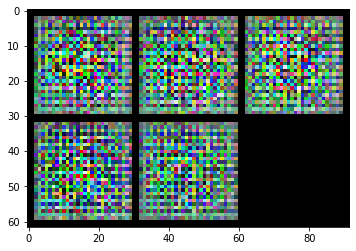

torch.Size([5, 3, 28, 28])
Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)


In [7]:
###Generator 테스트
test_gen = Generator(64,3,64)
test_noise = get_noise(5,64).requires_grad_()
print(test_noise.size())
gen_result = test_gen(test_noise)
show_tensor_image(gen_result)
print(gen_result.size())
print(test_gen)

In [8]:
class Discriminator(nn.Module):
  def __init__(self,im_ch=3, hidden_dim=16):
    super(Discriminator,self).__init__()
    self.dis = nn.Sequential(
        self.make_d_block(im_ch, hidden_dim),
        self.make_d_block(hidden_dim, hidden_dim*2),
        self.make_d_block(hidden_dim *2 , 1,final_layer = True)
    )

  def make_d_block(self, in_ch, out_ch, kernel_size=4, stride=2, final_layer=False):
    if final_layer:
      return nn.Sequential(
          nn.Conv2d(in_ch, out_ch, kernel_size, stride),
          # nn.Flatten(),
          # nn.Linear(36,1),
          # nn.Sigmoid()
      )
    else:
      return nn.Sequential(
          nn.Conv2d(in_ch, out_ch, kernel_size, stride),
          nn.BatchNorm2d(out_ch),
          nn.LeakyReLU(negative_slope = 0.2, inplace=True)
                )
      
  def forward(self, image):
    out = self.dis(image)
    out = out.view(len(out),-1)
    return out


In [9]:
### Discriminator test
test_gen = Generator(z_dim = 64, im_ch = 3,hidden_dim = 64)
test_noise = get_noise(n_samples = 100,z_dim = 64).requires_grad_()
print(test_noise.size())
gen_result = test_gen(test_noise)
print(gen_result.size())
test_dis = Discriminator(3,64)
dis_result = test_dis(gen_result)
print(dis_result.size())
# print(dis_result)

torch.Size([100, 64])
torch.Size([100, 3, 28, 28])
torch.Size([100, 1])


In [47]:
####하이퍼파라미터
# criterion = nn.BCEWithLogitsLoss()
##critic loss로쓸꺼임

n_epochs = 60        #몇 epoch
z_dim = 64              #noise 의 dimension
display_step = 500      #몇번마다 visualize
batch_size = 128      
lr = 0.0002

##for ADAM
beta_1 = 0.5            
beta_2 = 0.999

##for critic loss
c_lambda = 5
crit_repeats = 5
# device = 'cpu'
device = 'cuda'

transform = transforms.Compose([
    transforms.RandomAffine(degrees=(10,20), translate=(0.1, 0.2), scale=(0.75,1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

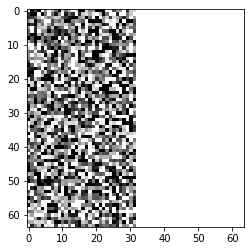

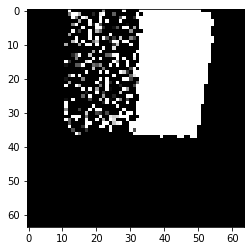

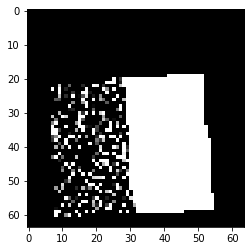

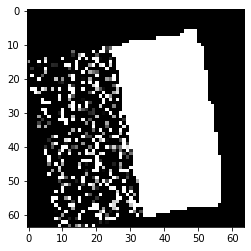

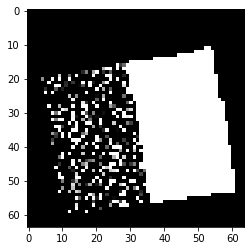

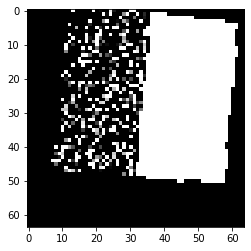

In [48]:
test1 = torch.randn(1,64,32)
test2 = torch.ones_like(test1)
test = torch.concat((test1,test2),dim=2)
show_tensor_image(test)
transform = transforms.Compose([
    transforms.RandomAffine(degrees=(10), translate=(0.1, 0.2), scale=(0.75,1)),
    # transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = [transform(test) for _ in range(5)]
for i in test_transforms:
  show_tensor_image(transform(i))

In [49]:
gen = Generator(z_dim,1,64).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

dis = Discriminator(1,64).to(device)
dis_opt = torch.optim.Adam(dis.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
dis = dis.apply(weights_init)

In [50]:
### gradient penalty를 위한 함수
def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def gradient_penalty(gradient):
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean(gradient_norm-1)
    penalty = torch.mul(penalty, penalty)
    return penalty

def get_gen_loss(crit_fake_pred):
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = -torch.mean(crit_real_pred) + torch.mean(crit_fake_pred) + c_lambda*gp
    return crit_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: -4.9735970041579565, discriminator loss: -124.46766815203324


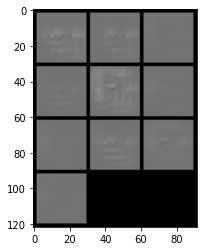

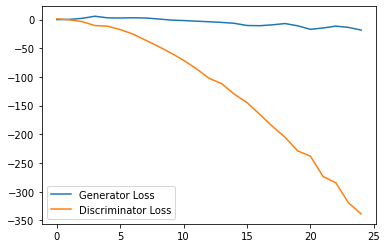

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: -8.30419620770216, discriminator loss: -649.4631540710452


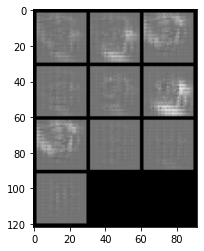

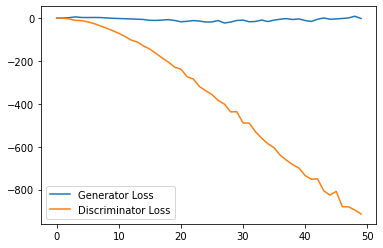

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: -30.492220109760762, discriminator loss: -548.8455129882815


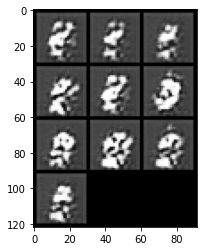

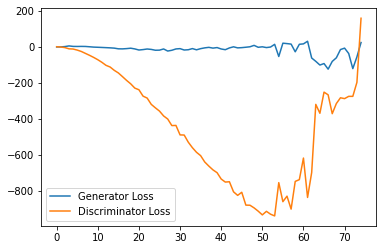

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: -10.296474876016378, discriminator loss: 138.72974338684097


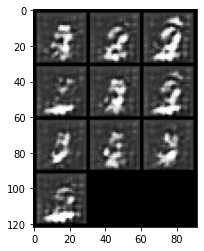

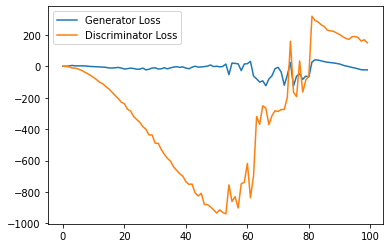

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: -33.02881792831421, discriminator loss: 58.23139884490967


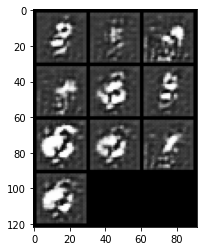

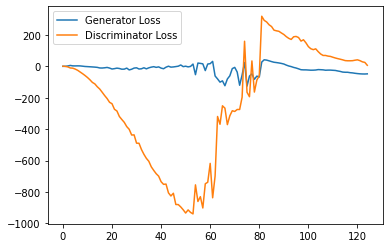

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: -48.782123779296874, discriminator loss: -16.941896293640138


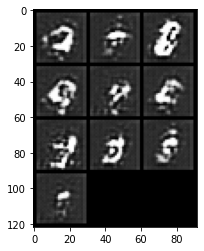

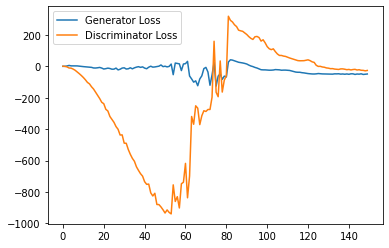

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: -52.784185989379885, discriminator loss: -29.921456218337976


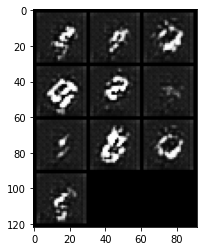

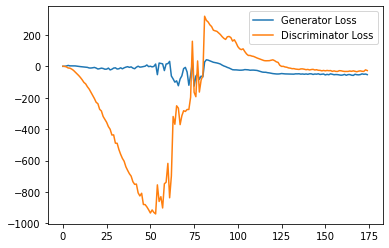

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: -52.241417552948, discriminator loss: -16.498297434616084


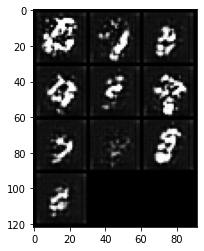

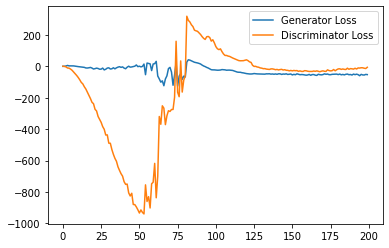

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: -53.77641250610352, discriminator loss: -3.786616442489625


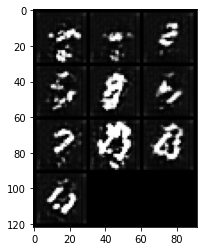

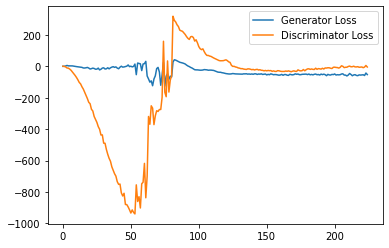

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: -55.61265362548828, discriminator loss: -3.4500820857048025


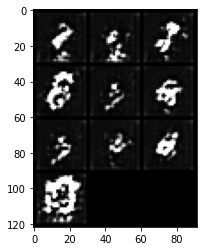

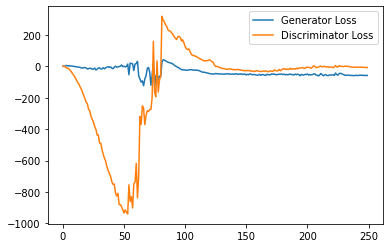

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: -56.381799476623534, discriminator loss: -8.746951216030114


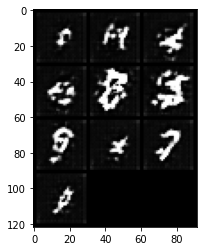

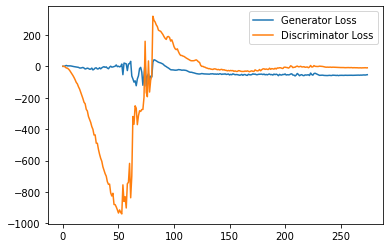

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: -53.062779762268065, discriminator loss: -9.982893699312214


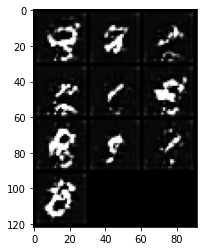

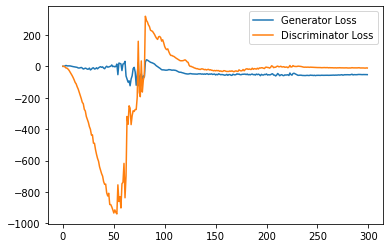

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: -52.395207252502445, discriminator loss: -10.464336854267124


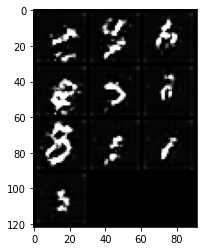

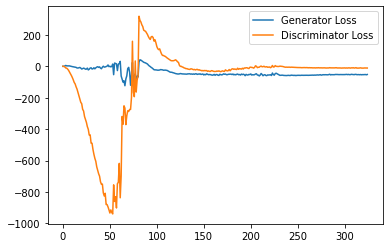

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: -51.35228802490234, discriminator loss: -11.096007144880284


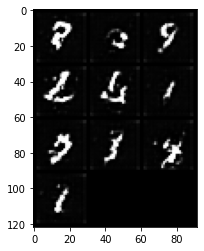

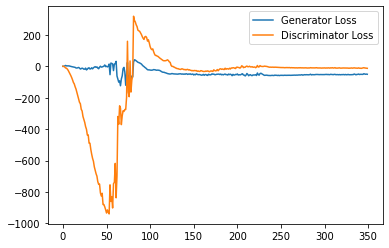

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: -46.777021057128906, discriminator loss: -10.499704499244693


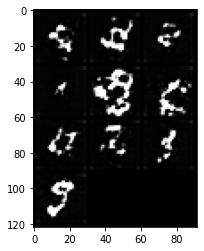

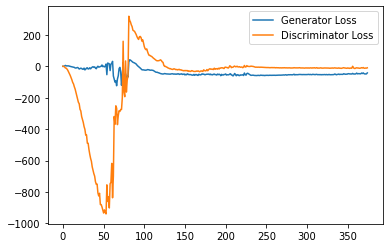

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: -47.650532516479494, discriminator loss: -10.395512162995338


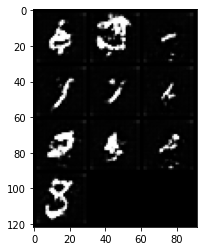

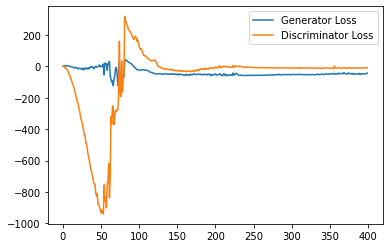

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: -46.802912406921386, discriminator loss: -10.864204346394548


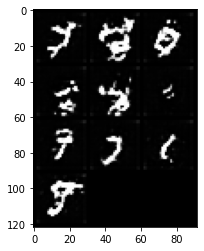

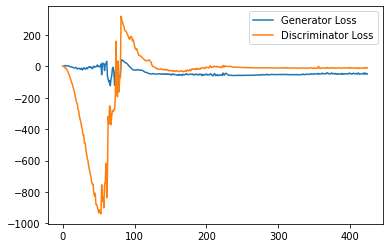

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: -49.563444770812985, discriminator loss: -11.032122744107243


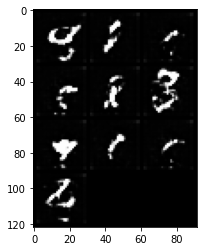

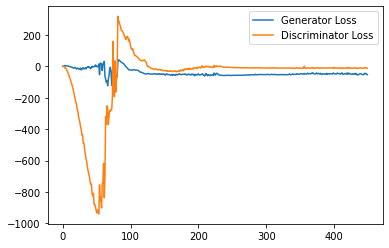

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: -49.732280395507814, discriminator loss: -11.215920123338698


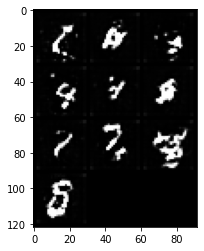

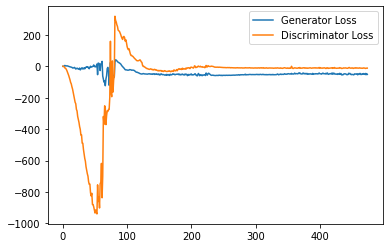

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: -44.430919261932374, discriminator loss: -10.943121882224078


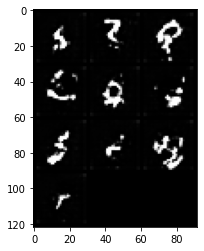

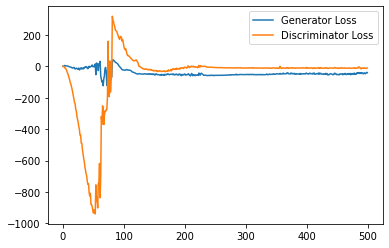

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: -41.70161355400086, discriminator loss: -11.945132051157952


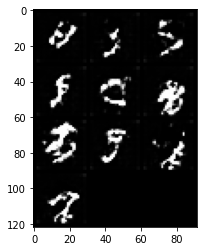

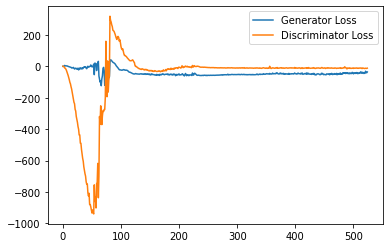

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: -36.47204439926148, discriminator loss: -12.08662020676135


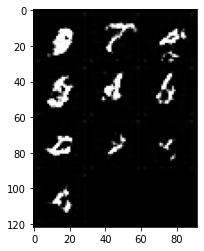

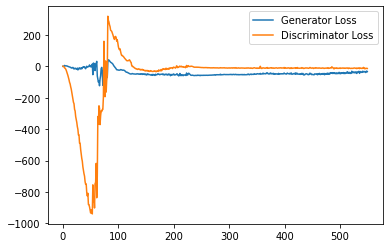

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: -33.54934525251389, discriminator loss: -12.363440617871282


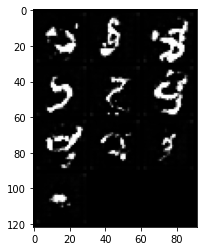

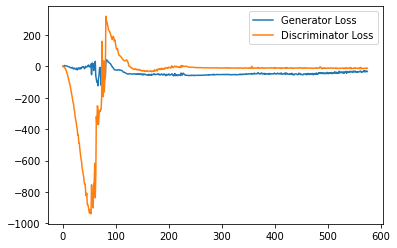

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: -30.122444880485535, discriminator loss: -13.068790186190618


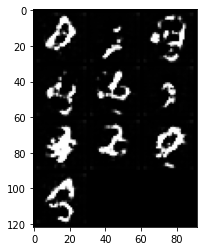

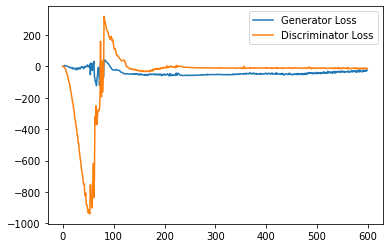

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: -30.32313374328613, discriminator loss: -12.610041527485848


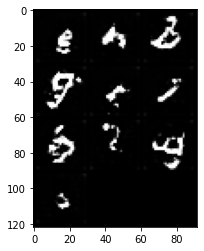

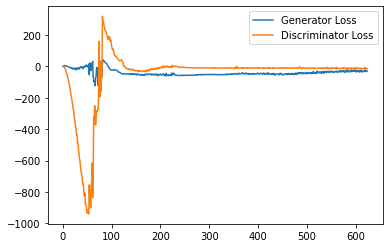

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: -26.790872168779373, discriminator loss: -13.758560322952274


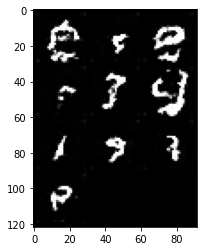

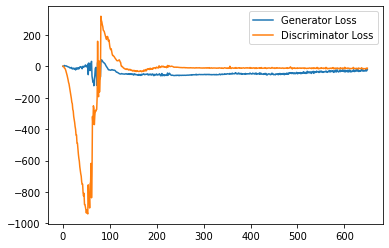

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: -25.67484802174568, discriminator loss: -13.224035407018654


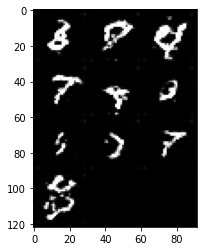

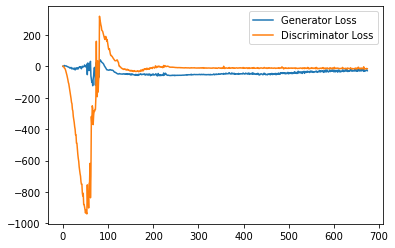

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: -23.793746464550495, discriminator loss: -13.076438903021803


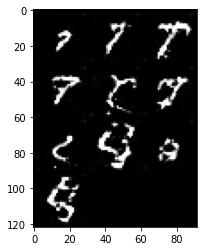

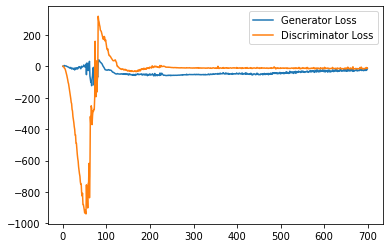

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: -21.868434449672698, discriminator loss: -13.441673372173307


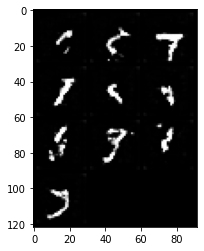

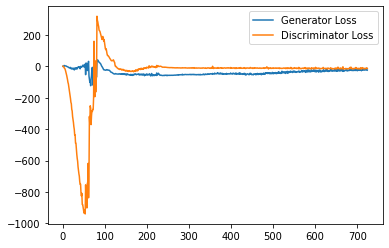

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: -19.977449704885483, discriminator loss: -14.259636216592769


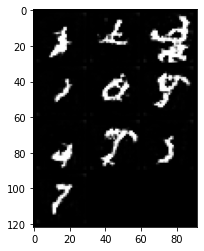

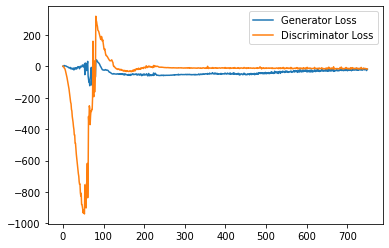

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: -17.984855289310218, discriminator loss: -13.553759560060493


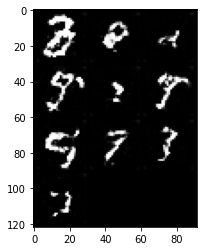

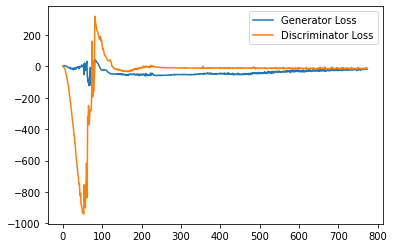

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: -17.98329785208404, discriminator loss: -14.793510878515246


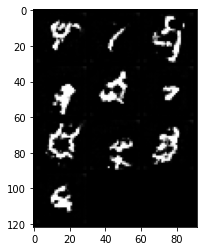

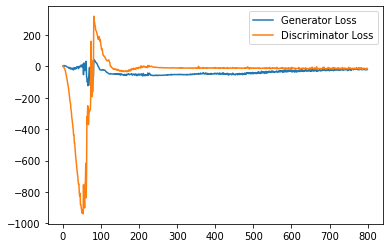

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: -18.179864699542524, discriminator loss: -14.335251602649686


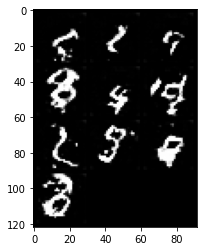

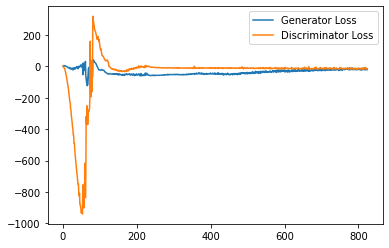

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: -17.87115453436971, discriminator loss: -14.281069479632379


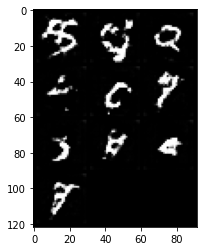

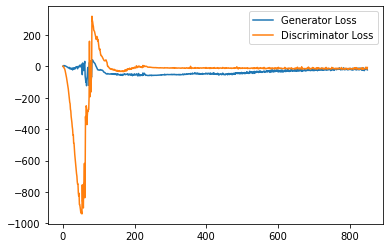

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: -18.410540089666842, discriminator loss: -15.815003333878511


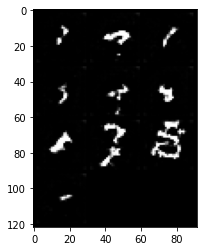

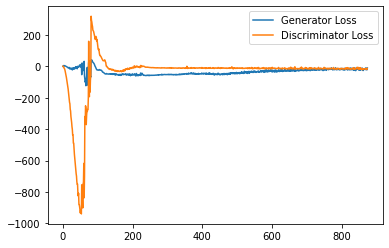

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: -17.47401504674554, discriminator loss: -13.435401158881197


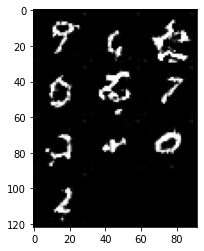

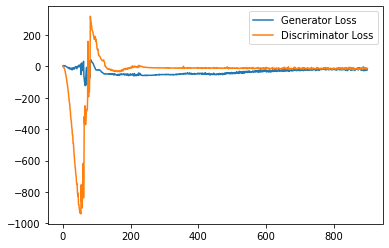

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: -19.219724795147776, discriminator loss: -15.072928904724135


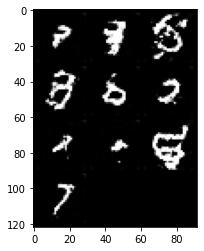

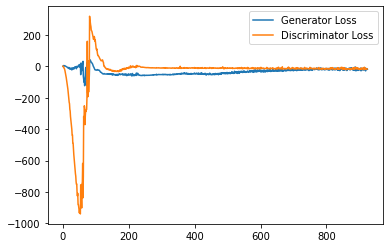

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: -21.151506359398365, discriminator loss: -13.756974288821217


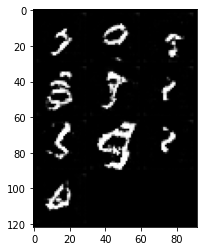

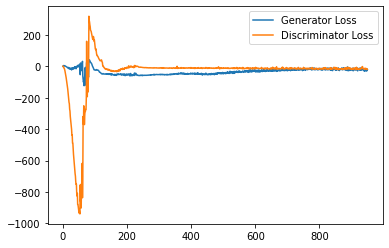

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: -22.311748169869183, discriminator loss: -13.754457283282276


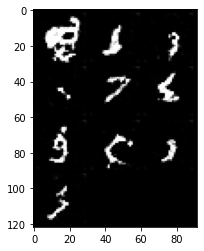

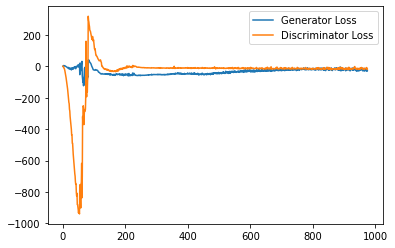

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: -25.25612171858549, discriminator loss: -10.98408779067994


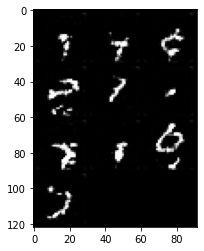

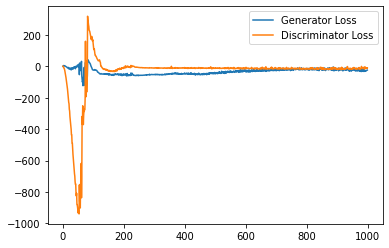

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: -28.931546020686625, discriminator loss: -12.068782003760335


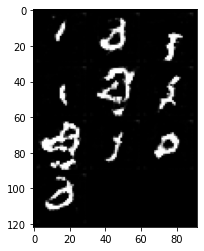

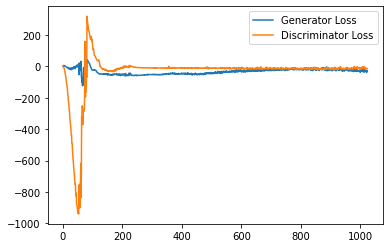

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: -28.264380197048187, discriminator loss: -14.812480784058586


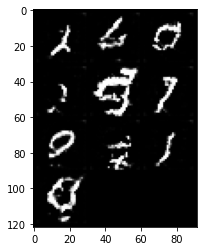

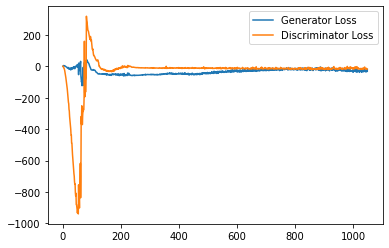

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: -28.239574566602705, discriminator loss: -13.716778053975101


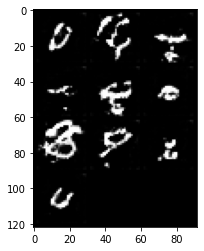

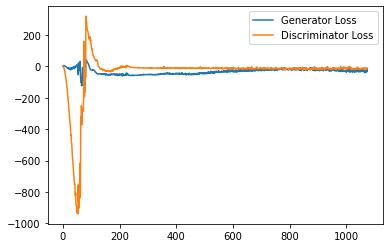

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: -30.51281827235222, discriminator loss: -15.204323324584958


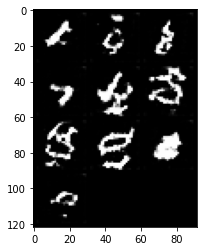

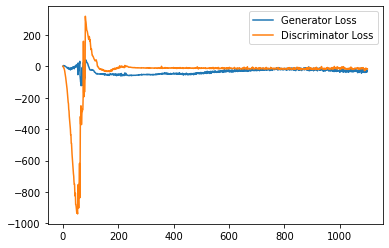

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: -26.386292503923176, discriminator loss: -14.574606400823589


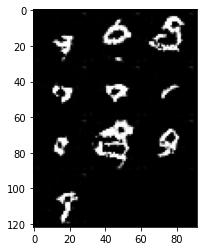

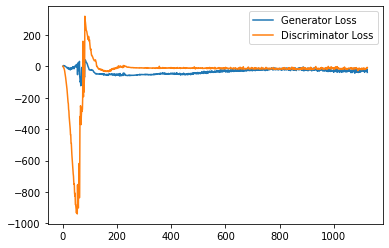

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: -29.825442314863206, discriminator loss: -12.65904705688954


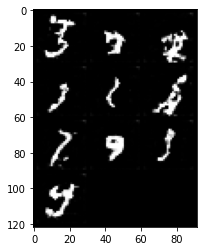

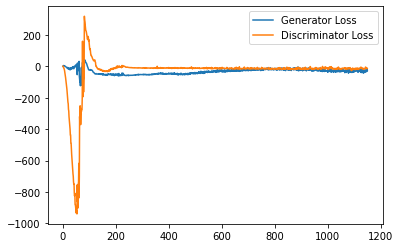

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50, step 23500: Generator loss: -33.84087765955925, discriminator loss: -11.86515524413585


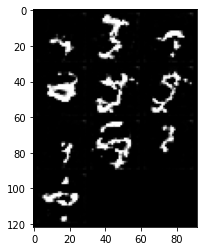

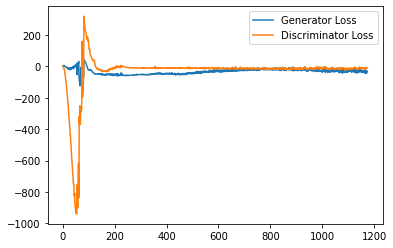

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51, step 24000: Generator loss: -40.81634815216064, discriminator loss: -13.416314929389955


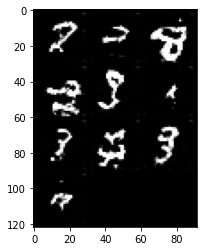

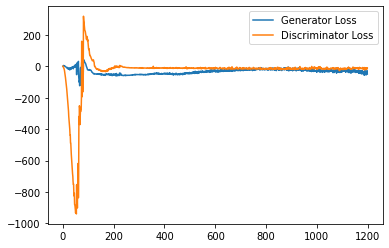

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52, step 24500: Generator loss: -40.231638401031496, discriminator loss: -15.363924919438368


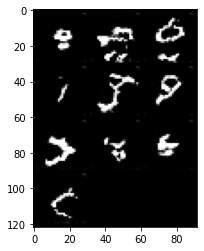

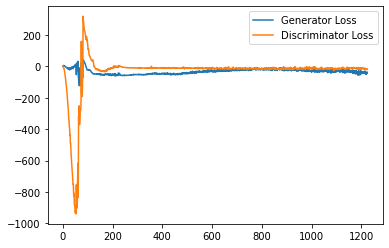

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53, step 25000: Generator loss: -36.587606041193006, discriminator loss: -13.372559452629087


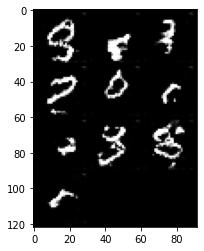

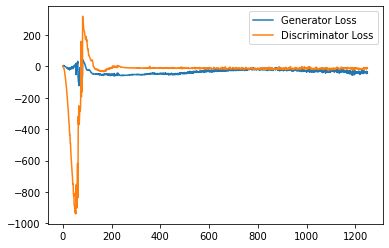

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54, step 25500: Generator loss: -40.540603094697, discriminator loss: -13.089861584901808


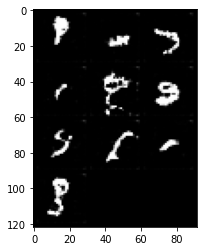

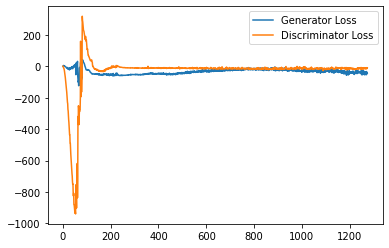

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55, step 26000: Generator loss: -46.324262417554856, discriminator loss: -13.019375651979463


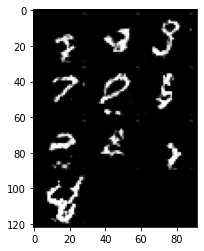

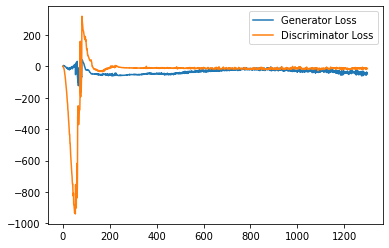

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56, step 26500: Generator loss: -45.57006793642044, discriminator loss: -12.864533629894263


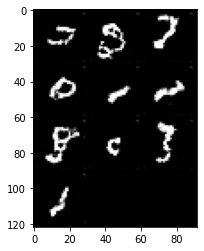

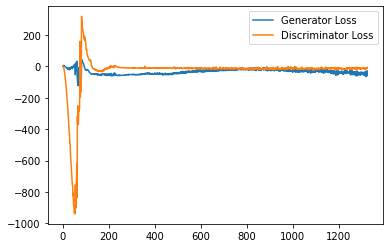

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57, step 27000: Generator loss: -51.900241207122804, discriminator loss: -12.942988386940957


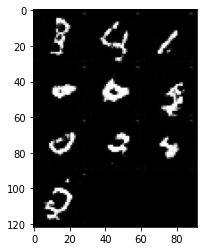

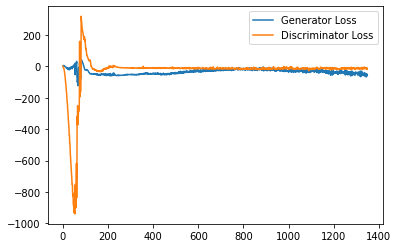

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58, step 27500: Generator loss: -52.6803709154129, discriminator loss: -14.022927170896528


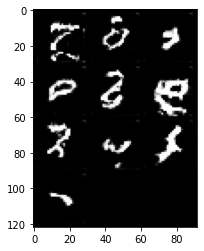

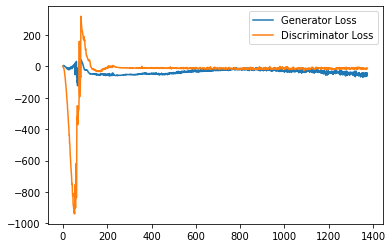

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59, step 28000: Generator loss: -50.5655177116394, discriminator loss: -13.461811245656019


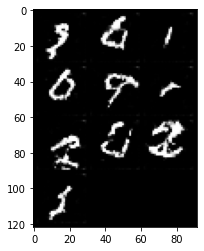

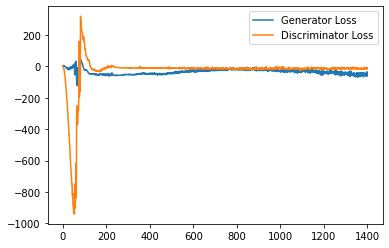

In [51]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)

    moving_average_dis_loss = 0
    for _ in range(crit_repeats):
    ####discriminator 학습하기
      dis_opt.zero_grad()

    ###L = C(x) - C(G(z))
      fake_noise = get_noise(cur_batch_size, z_dim, device=device)
      fake_img = gen(fake_noise)
      epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
      gradient=get_gradient(dis,real,fake_img.detach(),epsilon)
      gp = gradient_penalty(gradient)
      D_loss = get_crit_loss(dis(fake_img.detach()),dis(real),gp,c_lambda)

      moving_average_dis_loss+=D_loss.item() / 5

      D_loss.backward(retain_graph=True)
      dis_opt.step()

    discriminator_losses += [moving_average_dis_loss]

### generator 학습하기
    gen_opt.zero_grad()
    fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
    fake_2 = gen(fake_noise_2)
    dis_fake_pred = dis(fake_2)
    
    gen_loss = get_gen_loss(dis_fake_pred)
    gen_loss.backward()

    gen_opt.step()


    generator_losses += [gen_loss.item()]

    if cur_step % display_step == 0 and cur_step > 0:
        gen_mean = sum(generator_losses[-display_step:]) / display_step
        dis_mean = sum(discriminator_losses[-display_step:]) / display_step
        print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {dis_mean}")
        show_tensor_image(fake_img,10,5)
        # show_tensor_image(real)
        step_bins = 20
        num_examples = (len(generator_losses) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins), 
            torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Generator Loss"
        )
        plt.plot(
            range(num_examples // step_bins), 
            torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Discriminator Loss"
        )
        plt.legend()
        plt.show()

    cur_step += 1

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# torch.save(gen.state_dict(), '/content/drive/My Drive/last_run')

# 새 섹션

In [65]:
load_test_gen = Generator(z_dim,1,64).to(device)
load_test_gen.load_state_dict(torch.load('/content/drive/My Drive/pretrained_MNIST'))

<All keys matched successfully>

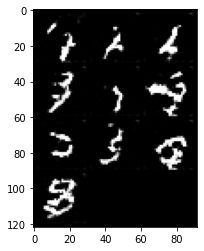

In [67]:
noise_vector = get_noise(10,z_dim,device=device)
show_tensor_image(load_test_gen(noise_vector))

In [61]:
## celeb a generator 
class Generator2(nn.Module):
  def __init__(self, z_dim=10, im_ch=1, hidden_dim=64):
    super(Generator2, self).__init__()
    self.z_dim=z_dim
    #outputs(3,28,28)
    # self.gen = nn.Sequential( ##(z_dim,1,1)
    #     self.make_g_block(z_dim, hidden_dim * 4),#( 64*4,3,3)
    #     self.make_g_block(hidden_dim * 4, hidden_dim * 2,kernel_size=4, stride=1),#(64*2,6,6)
    #     self.make_g_block(hidden_dim * 2, hidden_dim),#(64,13,13)
    #     self.make_g_block(hidden_dim, im_ch, kernel_size = 4, final_layer = True),  #(1,28,28) 
    # )
    # outputs (3,64,64)
    self.gen = nn.Sequential(
        self.make_g_block(z_dim, hidden_dim * 8),
        self.make_g_block(hidden_dim * 8, hidden_dim * 4),
        self.make_g_block(hidden_dim * 4, hidden_dim * 2),
        self.make_g_block(hidden_dim * 2, hidden_dim),
        self.make_g_block(hidden_dim, im_ch, kernel_size = 4, final_layer = True),   
    )

  def make_g_block(self, in_ch, out_ch, kernel_size=3, stride=2, final_layer=False):
    '''
    generator block을 반환하는 함수 
    '''
    ## 마지막 layer는 Transposed > Tanh
    if final_layer:
      return nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride),
                           nn.Tanh())
   ##마지막이 아니라면 Transposed > BatchNorm > ReLU (Leaky로 할까? 몰?루)
    else:
      return nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride),
                           nn.BatchNorm2d(out_ch),
                           nn.ReLU(inplace=True))
      ##                   nn.LeakyReLU(negative_slope = 0.2, inplace=True))
      
  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim,1,1)
    return self.gen(x)
  

In [63]:
gen2 = Generator2(z_dim=64,im_ch=3,hidden_dim=64).to(device)
gen2_dict = torch.load("/content/drive/My Drive/pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen2.load_state_dict(gen2_dict)
gen2.eval()

Generator2(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 

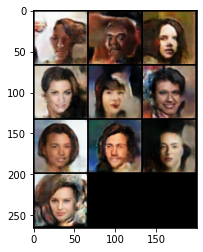

In [68]:

noise_vector = get_noise(10,64,device=device)
show_tensor_image(gen2(noise_vector))